In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
from skimage.transform import resize

# Bouts
from megabouts.utils.utils_bouts import NameCat

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

# Pipeline
from megabouts.tracking_data.dataset import Dataset_TailTracking
from megabouts.pipeline.tail_tracking import PipelineTailTracking
from megabouts.pipeline.cfg import ConfigTailPreprocess,ConfigSparseCoding,ConfigTailSegmentation


In [7]:

data_folder='H://HeadRestrainedDataset//all_csv//'
protocol_name='all_csv'
path='H://HeadRestrainedDataset//all_csv//'

filelist=[]
for file in os.listdir(path):
    if file.endswith(".csv"):
        filelist.append(os.path.join(path, file))


In [8]:
filelist

['H://HeadRestrainedDataset//all_csv//2021-09-28-nefma-6dpf-f2-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-28-nefma-6dpf-f3-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-28-nefma-6dpf-f4-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-28-nefma-6dpf-f6-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-29-nefma-7dpf-f1-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-29-nefma-7dpf-f3-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-29-nefma-7dpf-f4-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-29-nefma-7dpf-f6-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-09-29-nefma-7dpf-f8-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-10-06-nefma-6dpf-f1-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-10-06-nefma-6dpf-f2-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-10-06-nefma-6dpf-f4-all_logs.csv',
 'H://HeadRestrainedDataset//all_csv//2021-10-06-nefma-6dpf-f6-a

In [9]:

stop = False
filelist = ['2021-10-07-nefma-7dpf-f1-all_logs']
df = pd.read_csv('H://HeadRestrainedDataset//all_csv//'+filelist[0]+'.csv')
#df = pd.read_csv(filelist[0])

NumSegment = 16

relative_tail_angle = df[['angle'+str(i) for i in range(NumSegment)]]
relative_tail_angle = relative_tail_angle.values

cumul_tail_angle=np.cumsum(relative_tail_angle,1)
cumul_tail_angle[cumul_tail_angle<-10]=np.nan

tracking_data = Dataset_TailTracking(fps=700,tail_angle=cumul_tail_angle)

tail_angle was rescaled to have size to have 10 segments


# Create Pipeline

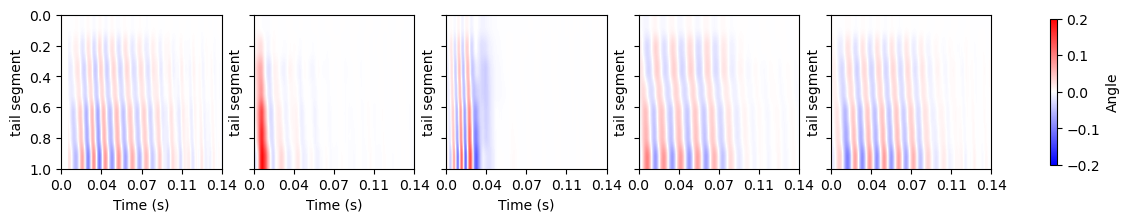

In [10]:

Dict = np.load('../megabouts/sparse_coding/5atomsDictHR.npy')

D = Dict

fig, (ax) = plt.subplots(1,5,figsize=(15,2), sharex=True,sharey=True)#,constrained_layout=True)

for i in range(D.shape[-1]):
    #ax[i].title(str(i))
    im = ax[i].imshow(D[:,:,i].T,aspect='auto',vmin=-0.2,vmax=0.2,cmap='bwr',extent=[0,100,1,0])
    ax[i].set_ylabel('tail segment')
    #ax[i,0].set_xlabel('Time (s)')
    ax[i].set_xticks(np.linspace(0,100,5))
    ax[i].set_xticklabels(np.round(np.linspace(0,100/700,5),2))


ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[2].set_xlabel('Time (s)')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Angle')
plt.show()

In [17]:
cfg_preprocess = ConfigTailPreprocess(fps=700,num_pcs=3,limit_na_ms=100,
                                      baseline_method='whittaker',baseline_params={'fps':700,'lmbda':1e4})

cfg_sparse_coding = ConfigSparseCoding(fps=700,Dict=Dict,lmbda=0.01,gamma=0.15,mu=0.15,window_inhib_ms=85)


cfg_segment = ConfigTailSegmentation(fps=700,
                                     peak_prominence=0.4,min_code_height=1,min_spike_dist_ms=200,
                                     margin_before_peak_ms=40,bout_duration_ms=200)



pipeline = PipelineTailTracking(cfg_preprocess,
                                cfg_sparse_coding,
                                cfg_segment)

# Tuning baseline parameter fc

In [18]:
tail_angle_clean,baseline = pipeline.preprocess(tracking_data.tail_angle)

In [19]:
'''from preprocessing.baseline import compute_baseline

x = tail_angle_clean[:,6]

#baseline = compute_baseline(x,method='slow', params = {'fps':700})
#baseline = compute_baseline(x,method='beads', params = {'fps':700,'fc':0.001,'lmbda':1})
baseline = compute_baseline(x,method='whittaker', params = {'fps':700,'lmbda':5*1e3})'''

"from preprocessing.baseline import compute_baseline\n\nx = tail_angle_clean[:,6]\n\n#baseline = compute_baseline(x,method='slow', params = {'fps':700})\n#baseline = compute_baseline(x,method='beads', params = {'fps':700,'fc':0.001,'lmbda':1})\nbaseline = compute_baseline(x,method='whittaker', params = {'fps':700,'lmbda':5*1e3})"

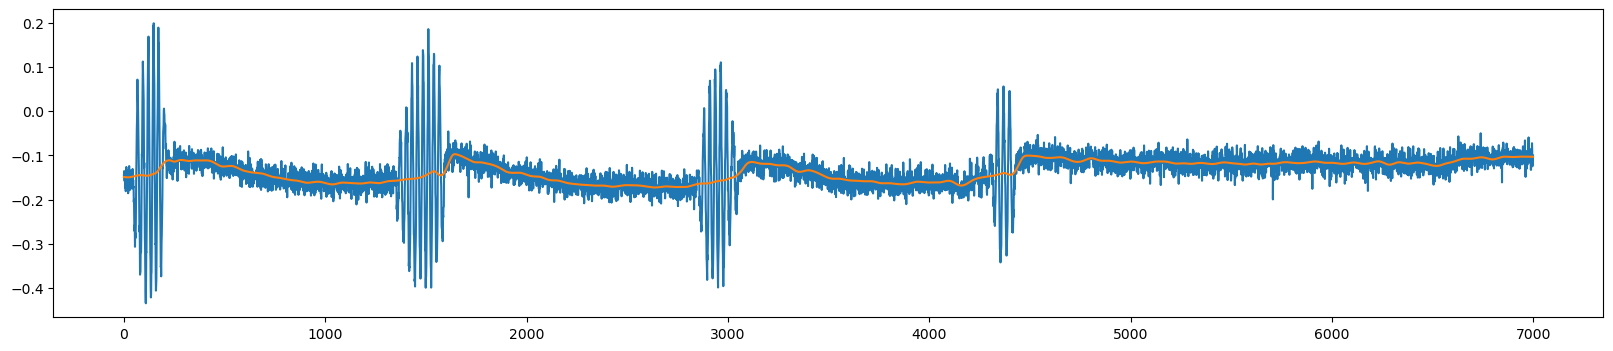

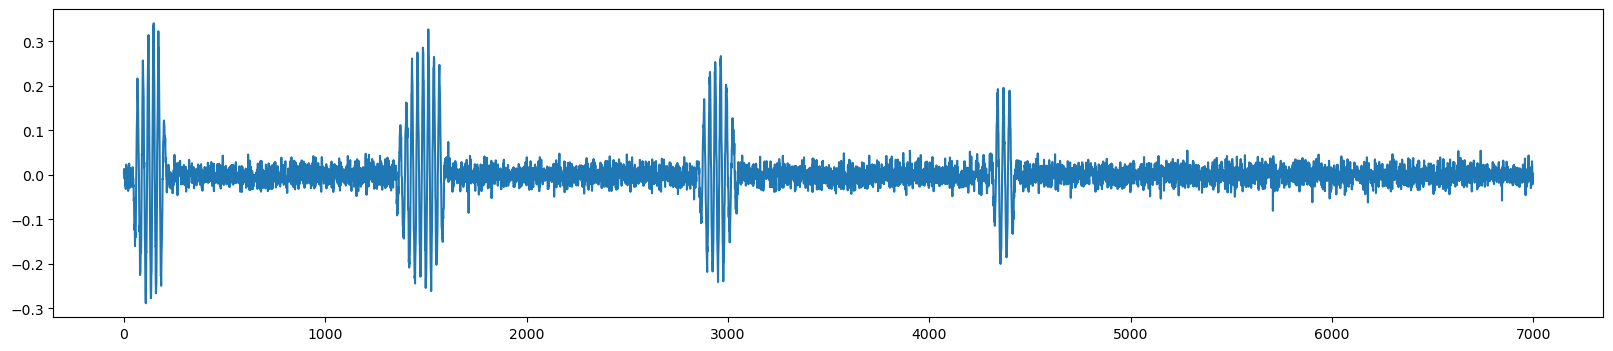

In [32]:
Duration = 700*10
#IdSt = np.random.choice([1099654,1241450,915610,232389,285738])
IdSt = np.random.randint(0.8*len(tail_angle_clean),len(tail_angle_clean))
plt.figure(figsize=(20,4))
plt.plot(tail_angle_clean[IdSt:IdSt+Duration,6])
plt.plot(baseline[IdSt:IdSt+Duration,6])
plt.show()

plt.figure(figsize=(20,4))
plt.plot((tail_angle_clean-baseline)[IdSt:IdSt+Duration,6])
plt.show()

In [33]:
res = pipeline.run(tracking_data.tail_angle)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  3.38e+03  1.49e+03  2.45e+04  8.11e+03  2.86e+03  4.02e-01  4.55e+00  1.50e+00
   1  6.03e+03  1.34e+03  2.60e+04  2.17e+04  7.80e+03  8.60e-01  1.21e+00  1.50e+00
   2  7.12e+03  1.81e+03  2.40e+04  2.55e+04  8.30e+03  9.04e-01  1.52e-01  1.23e+00
   3  6.26e+03  1.94e+03  1.62e+04  2.03e+04  7.39e+03  5.99e-01  2.72e-01  2.92e+00
   4  5.91e+03  2.11e+03  1.33e+04  1.67e+04  7.71e+03  2.49e-01  2.85e-01  4.22e+00
   5  6.38e+03  2.09e+03  1.40e+04  1.80e+04  9.69e+03  1.88e-01  1.74e-01  3.84e+00
   6  6.09e+03  2.10e+03  1.25e+04  1.60e+04  9.73e+03  1.71e-01  1.47e-01  3.84e+00
   7  5.93e+03  2.14e+03  1.15e+04  1.49e+04  9.58e+03  1.53e-01  1.05e-01  3.84e+00
   8  5.86e+03  2.19e+03  1.10e+04  1.40e+04  9.77e+03  1.00e-01  9.89e-02  4.51e+00
   9  5.89e+03  2.18e+03  1.09e+04  1.35e+04  1.04e+04  7.68e-02 

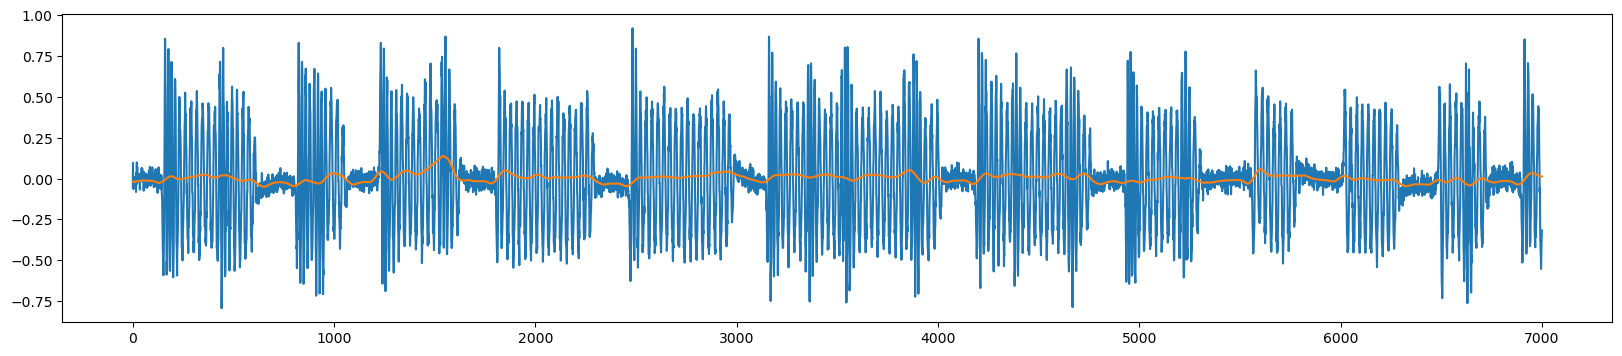

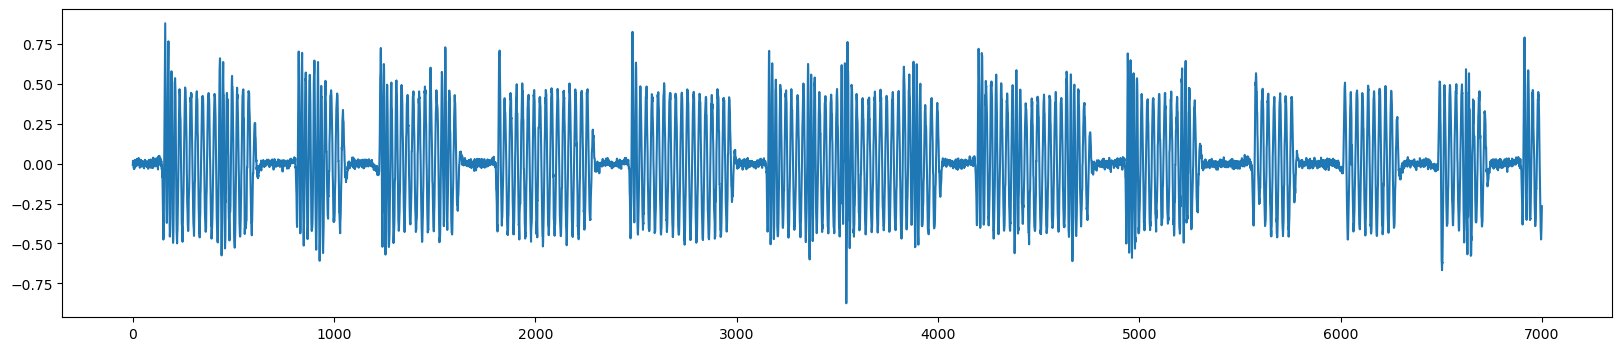

In [67]:
Duration = 700*10
IdSt= np.random.randint(baseline.shape[0]-Duration)
plt.figure(figsize=(20,4))
plt.plot(res.tracking_data.tail_angle[IdSt:IdSt+Duration,6])
plt.plot(baseline[IdSt:IdSt+Duration,6])
plt.show()
plt.figure(figsize=(20,4))
plt.plot(res.tracking_data_clean.tail_angle[IdSt:IdSt+Duration,6])
plt.show()

In [41]:
decomposition_original = np.copy(res.sparse_code.decomposition)
forward_id = [0,3,4]
turn_id = [1]
fast_id = [2]
decomposition = np.zeros((decomposition_original.shape[0],3))
decomposition[:,0] = np.sum(decomposition_original[:,forward_id],axis=1)
decomposition[:,1] = np.sum(decomposition_original[:,turn_id],axis=1)
decomposition[:,2] = np.sum(decomposition_original[:,fast_id],axis=1)

In [42]:
decomposition.shape

(1266204, 3)

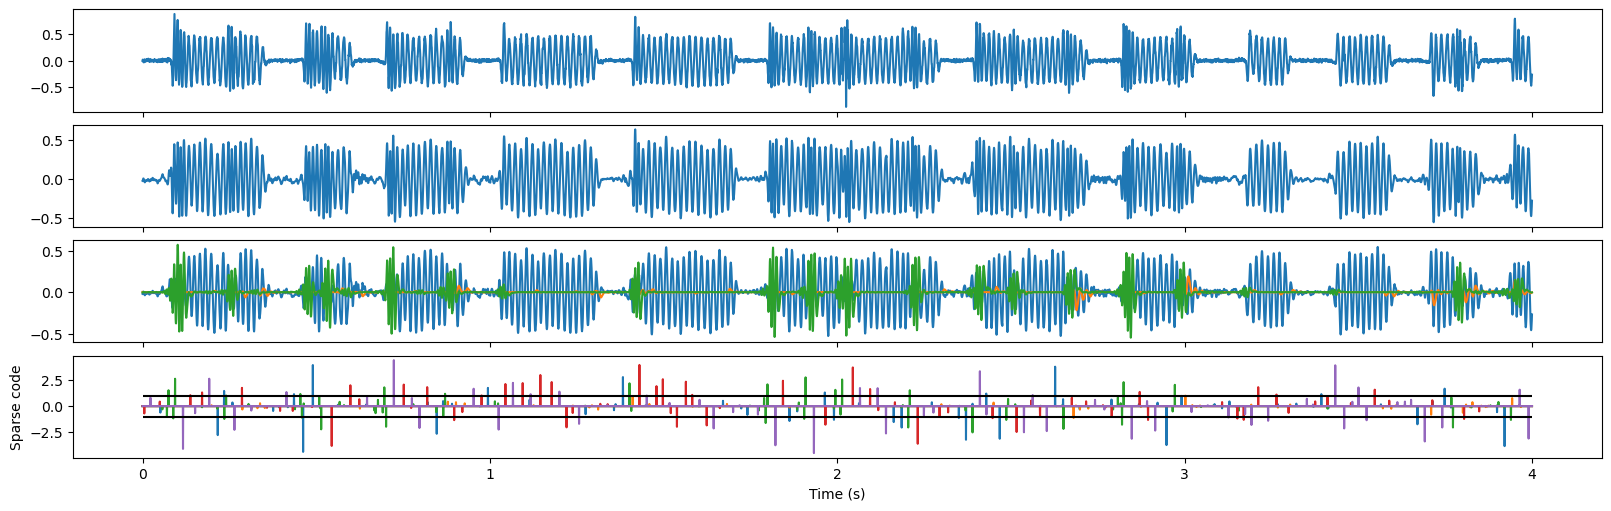

In [68]:

fig, (ax) = plt.subplots(4,1,figsize=(16,5), sharex=True,constrained_layout=True)
ax[0].plot(res.tracking_data_clean.tail_angle[IdSt:IdSt+Duration,6])
ax[1].plot(res.sparse_code.tail_angle_hat[IdSt:IdSt+Duration,6])
ax[2].plot(decomposition[IdSt:IdSt+Duration,:])
ax[3].plot(res.sparse_code.z[IdSt:IdSt+Duration,:])
ax[3].hlines(cfg_segment.min_code_height,0,Duration,color='k')
ax[3].hlines(-cfg_segment.min_code_height,0,Duration,color='k')
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Sparse code')
ax[3].set_xticks(np.linspace(0,Duration,5))
ax[3].set_xticklabels(np.arange(0,5))
plt.show()